In [ ]:
!pip install transformers
!pip install torchinfo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, AdamW

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


from sklearn.feature_extraction.text import CountVectorizer
# from torchinfo import summary

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# loading the dataset
dataset = pd.read_csv('/content/drive/MyDrive/fake reviews dataset.csv')

In [ ]:
dataset.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
dataset.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

In [ ]:
dataset.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [ ]:
class_names = list(np.unique(dataset["label"]))
class_names

['CG', 'OR']

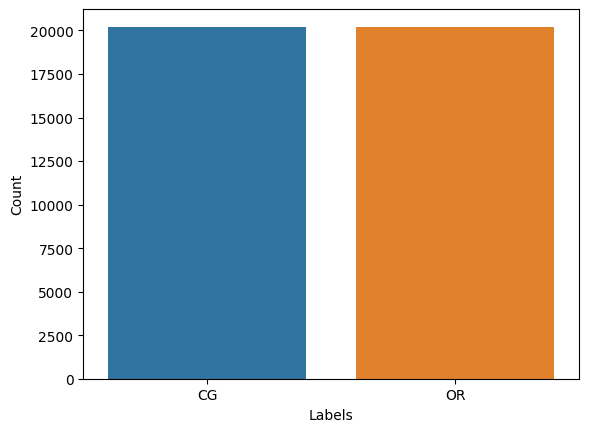

In [ ]:
count_label = dataset["label"].value_counts()
sns.barplot(x=np.array(class_names),y=count_label.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

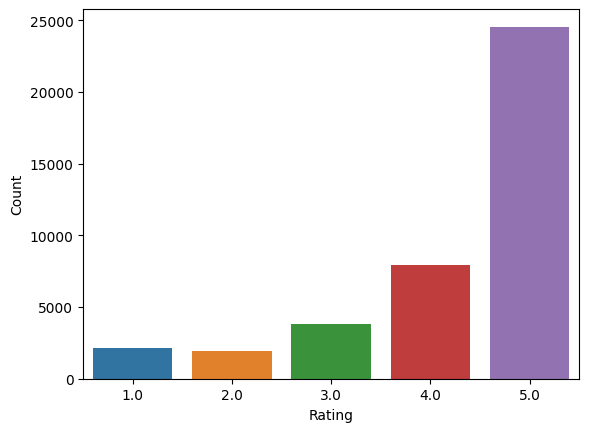

In [ ]:
count_rating = dataset["rating"].value_counts()
sns.barplot(x=count_rating.index,y=count_rating.values)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
encoder = OrdinalEncoder()
dataset["label"] = encoder.fit_transform(dataset[["label"]])

Text(0.5, 0, 'Token count')

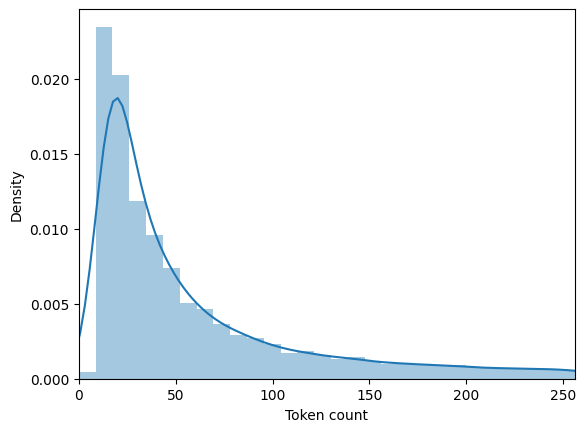

In [ ]:

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataset.text_)

token_lens = np.sum(X.toarray(), axis = 1)

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
# create the class of Dataset to process data
class FakeReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation = True,
            pad_to_max_length=True,
            return_tensors='pt',
            )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [ ]:
# create the DataLoader to redesign the dataset into batch size
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = FakeReviewDataset(
        reviews = df.text_.to_numpy(),
        targets = df.label.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size)

In [ ]:
# Training function for each epoch on the training set
def train_epoch(model, data_loader, optimizer, device, scheduler, batch_size):
    model = model.train()
    losses = 0
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        # Get model outputs
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        # get the loss value
        loss = outputs.loss
        correct_predictions += torch.sum(preds == targets).item() / batch_size
        losses += loss

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_loss = (losses/len(data_loader)).item()
    train_acc = correct_predictions/len(data_loader)

    return train_acc , train_loss

In [ ]:
# the evaluation function for the validation set
def eval_model(model, data_loader, device, batch_size):
    model = model.eval()

    losses = 0
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model outputs
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            loss = outputs.loss

            correct_predictions += torch.sum(preds == targets).item() / batch_size
            losses += loss

    val_loss = (losses/len(data_loader)).item()
    val_acc = correct_predictions/len(data_loader)

    return val_acc , val_loss

In [ ]:
# the evaluation function for the test set
def test_set_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds)
            prediction_probs.extend(logits)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, prediction_probs, real_values

In [ ]:
MAX_LEN = 150
BATCH_SIZE = 64
# Set the model name
MODEL_NAME = 'bert-base-uncased'

# Build a BERT based tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load the basic BERT model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
summary(model,dtypes=[torch.long])

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 10

In [ ]:
# split the dataset inot 3 parts
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(32345, 4) (4043, 4) (4044, 4)


In [ ]:
 # Create train, val, and test data loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Number of iterations
EPOCHS = 5

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
history = {'train_loss': [],
           'train_acc': [],
           'val_loss': [],
           'val_acc': []}
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        BATCH_SIZE
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        BATCH_SIZE
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.10292281955480576 accuracy 0.9588068181818182
Val   loss 0.06533769518136978 accuracy 0.960693359375

Epoch 2/5
----------
Train loss 0.024553243070840836 accuracy 0.9902112154150198
Val   loss 0.05546639859676361 accuracy 0.972900390625

Epoch 3/5
----------
Train loss 0.007575417403131723 accuracy 0.9967267786561265
Val   loss 0.08415911346673965 accuracy 0.969482421875

Epoch 4/5
----------
Train loss 0.002428581239655614 accuracy 0.9981781126482213
Val   loss 0.17575612664222717 accuracy 0.9599609375

Epoch 5/5
----------
Train loss 0.0005491639021784067 accuracy 0.9987339426877471
Val   loss 0.1328485757112503 accuracy 0.96630859375



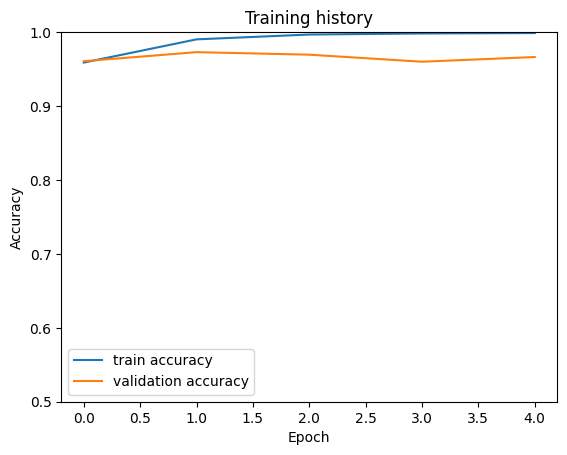

In [ ]:
# Plot training and validation accuracy
plt.plot( history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

In [ ]:
y_pred, y_pred_probs, y_test = test_set_predictions(
    model,
    test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.96      0.99      0.98      2017
          OR       0.99      0.96      0.97      2027

    accuracy                           0.98      4044
   macro avg       0.98      0.98      0.98      4044
weighted avg       0.98      0.98      0.98      4044



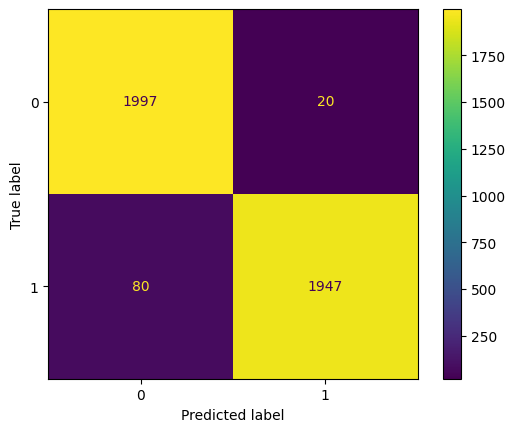

In [ ]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
#Saving the model:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "DL_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/DL_model_1.pth


### The batch size: 32, the size of length: 160

In [ ]:
MAX_LEN = 160
BATCH_SIZE = 32
# Set the model name
MODEL_NAME = 'bert-base-uncased'

# Build a BERT based tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load the basic BERT model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

history = {'train_loss': [],
           'train_acc': [],
           'val_loss': [],
           'val_acc': []}
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        BATCH_SIZE
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        BATCH_SIZE
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.10709985345602036 accuracy 0.9621970820969338
Val   loss 0.046927422285079956 accuracy 0.9781003937007874

Epoch 2/5
----------
Train loss 0.026919951662421227 accuracy 0.9919634025717112
Val   loss 0.06952759623527527 accuracy 0.9756397637795275

Epoch 3/5
----------
Train loss 0.009644176810979843 accuracy 0.9971871909000989
Val   loss 0.08834277093410492 accuracy 0.9781003937007874

Epoch 4/5
----------
Train loss 0.003173785749822855 accuracy 0.9990727002967359
Val   loss 0.1396910697221756 accuracy 0.9744094488188977

Epoch 5/5
----------
Train loss 0.0013254949590191245 accuracy 0.9994745301681504
Val   loss 0.1518498659133911 accuracy 0.9731791338582677



In [ ]:
y_pred, y_pred_probs, y_test = test_set_predictions(
    model,
    test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.95      0.99      0.97      2017
          OR       0.99      0.95      0.97      2027

    accuracy                           0.97      4044
   macro avg       0.97      0.97      0.97      4044
weighted avg       0.97      0.97      0.97      4044



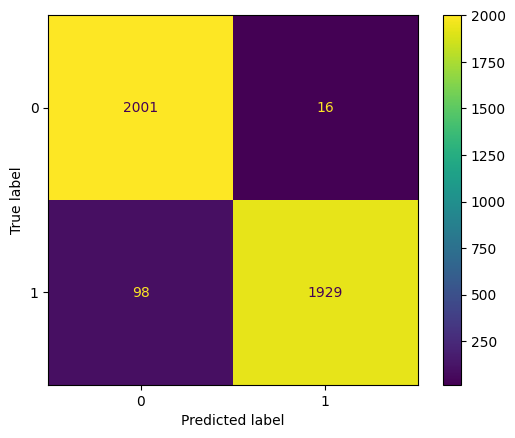

In [ ]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# running time: 70 minutes
info_memory = torch.cuda.mem_get_info()
memory = info_memory[1] - info_memory[0]
print("The total used memory is ", round(memory/2**30,2)," GB.")

The total used memory is  9.95  GB.


In [ ]:
# the function to predict labels for the Amazon review dataset
def predict_labels(model, review, tokenizer, max_len):
    model.eval()
    with torch.no_grad():
        encoding_reviews = tokenizer.encode_plus(
                  review,
                  add_special_tokens=True,
                  max_length= max_len,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  truncation = True,
                  pad_to_max_length=True,
                  return_tensors='pt',
                  )

        outputs = model(**encoding_reviews.to(device))
        predictions = outputs.logits.argmax(dim=1)

    return predictions

In [ ]:
# load the Amazon dataset after choosing through the similar score with the validation set
amazon_reviews = pd.read_csv('/content/drive/MyDrive/Top_Amazon_dataset.csv')

In [ ]:
# load Model 1
model.load_state_dict(torch.load('/content/drive/MyDrive/DL_model_1.pth'))

<All keys matched successfully>

In [ ]:
# predict the label for the Amazon dataset
labels = []
for review in amazon_reviews.reviews[:10000]:
  label = predict_labels(model, review, tokenizer, MAX_LEN)
  labels.append(label.item())


In [ ]:
# create the new Amazon dataset include labels

df_amazon = pd.DataFrame({"reviews": amazon_reviews.reviews[:10000],
                          "labels": labels})

file_path = "/content/drive/MyDrive/Amazon_reviews_labeled.csv"
df_amazon.to_csv(file_path, index=False)



In [ ]:
df_amazon.head()

,reviews,labels
0,"Story is great, print quality sucks: The story...",1
1,Not what I expected: This is one book that did...,1
2,Simplistic: I bought this book because a talk ...,1
3,Not our favorite: This book was recommended by...,1
4,"Not impressed: A lot of misspelled words, and ...",1
